# SENTIMENT ANALYSIS WITH FINANCIAL NEWS 

NATURAL LANGUAGE PROCESSING

# INRODUCTION

The Dataset is a combination of 2 datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. 
FiQA(Financial Opinion Mining and Question Answering) was created in 2018 as part of an effort to improve aspect-based sentiment analysis. Financial Phrasebank, a collection of 4840 sentences, is derived from the Lexis Nexis database, labelled by domain-expert annotators.

The goal of the kernel is to perform EDA and build a predictive model for sentiment classification. A sklearn model is fit and an accuracy of 83% is achieved on a random subset of the dataset.

# Installing and Importing Libraries

In [1]:
!pip install rake-nltk
!pip install textstat
!pip install stylecloud
!pip install spacy

import pandas as pd

import spacy
nlp = spacy.load('en_core_web_lg')
import textstat
from rake_nltk import Rake
r = Rake()
from textblob import TextBlob

import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns
import stylecloud
from IPython.display import Image


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report

import eli5

import warnings
warnings.filterwarnings('ignore')

In [2]:
 df = pd.read_csv("NLP_data.csv")

In [3]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.shape

(5842, 2)

# EDA

Target Distribution

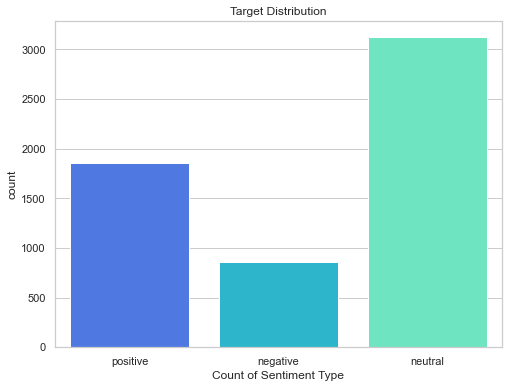

<Figure size 432x288 with 0 Axes>

In [5]:
sns.set_theme(style="whitegrid")
sns.set_palette('rainbow')
plt.figure(figsize=(8,6))
sns.countplot(x=df['Sentiment'])
plt.xlabel('Count of Sentiment Type')
plt.title('Target Distribution')
plt.show()
plt.savefig('Target Distribution')

Imbalanced dataset, 'neutral' class dominates the other 2 classes.

Calculating length of each sentence could let us know if sentence length varies substantially by class.

In [6]:
df['Sentence Length'] = df['Sentence'].apply(lambda x : textstat.lexicon_count(x, removepunct=True))

Plotting Sentence Lengths for each class

In [7]:
df_positive = df.loc[df['Sentiment'] == 'positive']
df_negative = df.loc[df['Sentiment'] == 'negative']
df_neutral = df.loc[df['Sentiment'] == 'neutral']


fig = make_subplots(rows=1, cols=3)

fig.append_trace(
    go.Box(name='Positive', y=df_positive['Sentence Length']),
    row=1, col=1
)

fig.append_trace(
    go.Box(name='Negative', y=df_negative['Sentence Length']),
    row=1, col=2
)

fig.append_trace(
    go.Box(name='Neutral', y=df_neutral['Sentence Length']),
    row=1, col=3
)



fig.update_layout(height=500, width=700, title_text="Distribution of Sentence Length across classes")
fig.show()

More or less the same across classes, so sentence length is invariant to sentiment type   

Extracting the top 100 phrases for each class

In [8]:
negative_corpus = df_negative['Sentence'].tolist()
negative_corpus = " ".join(negative_corpus)
r.extract_keywords_from_text(negative_corpus)
top_phrases_neg = r.get_ranked_phrases()[0:100]


positive_corpus = df_positive['Sentence'].tolist()
positive_corpus = " ".join(positive_corpus)
r.extract_keywords_from_text(positive_corpus)
top_phrases_pos = r.get_ranked_phrases()[0:100]


neutral_corpus = df_neutral['Sentence'].tolist()
neutral_corpus = " ".join(neutral_corpus)
r.extract_keywords_from_text(neutral_corpus)
top_phrases_neutral = r.get_ranked_phrases()[0:100]

pd.DataFrame({'Top Negative Phrases':top_phrases_neg,'Top Positive Phrases':top_phrases_pos,'Top Neutral Phrases':top_phrases_neutral})

,Top Negative Phrases,Top Positive Phrases,Top Neutral Phrases
0,tsla tullow oil suspends dividend amid oil pri...,companiescar insurer hastings group driving â ...,ñlt kostenlos sechs monate lang updates und ha...
1,70 billion bg deal meets shareholder skepticis...,irish housebuilder cairn homes plans london li...,neste oil corporation refining operation asset...
2,comparatives leave bitter taste london marketw...,borealis infrastructure putting together new s...,nasdaq omx helsinki major media comptel dynami...
3,"6 %, big trader added 10000 april put contract...",banco bpi entertainment one dispels itv takeov...,nasdaq omx helsinki major media comptel dynami...
4,fee failings finnish management software solut...,friends life lead ftse 100 gainers brazilian m...,petrofac share price rises despite â £ 30m costs
...,...,...,...
95,adjusted underlying ebitda actually amounts,finnish metal products company componenta oyj hel,finnish business software group affectogenimap...
96,tsla samsung currently occupies third place,old mutual q1 gross sales beat forecasts,finnish electronics contract manufacturer scan...
97,stora chief executive jouko karvinen,turkish steel company doktas dokumculuk ticaret,finnish aluminium products manufacturer nordic...
98,systems provider efore oyj said,scraps viiv ipo kesko agro lietuva,high winds also toppled three semi


In a financial news snippet; Companies, Top executives and Countries are the frequently referred-to entitites. spaCy's built in NER model can be used to determine their counts

In [9]:
def ner_counter(doc):
    gpe_count = 0
    org_count = 0
    person_count = 0
    money_count=0
    for tok in doc.ents:
        if tok.label_ == "GPE":
            gpe_count = gpe_count + 1
        elif tok.label_ == "ORG":
            org_count=org_count+1
        elif tok.label_ == "PERSON":
            person_count=person_count+1
        elif tok.label_ == "MONEY":
            money_count=money_count+1
    return (gpe_count,org_count,person_count,money_count)

sentences = df['Sentence'].tolist()
sentences = " ".join(sentences)
sentences = nlp(sentences)
entity_counts = list(ner_counter(sentences))
entity_df = {'Entity Type':['GPE', 'ORG', 'PERSON', 'MONEY'],
        'Count':entity_counts}
fig = px.bar(entity_df,x='Entity Type',y='Count',color='Entity Type')
fig.update_layout(height=500,width=500)

'ORG' refer to Companies here, have the highest count, most financial news will be about a select few large corporations.

'GPE' stands for Geopolitical entity, mostly countries or states within countries.

'PERSON' refers to specific people, mostly executives/politicians in the top brass.

# Wordcloud to plot the most frequent words

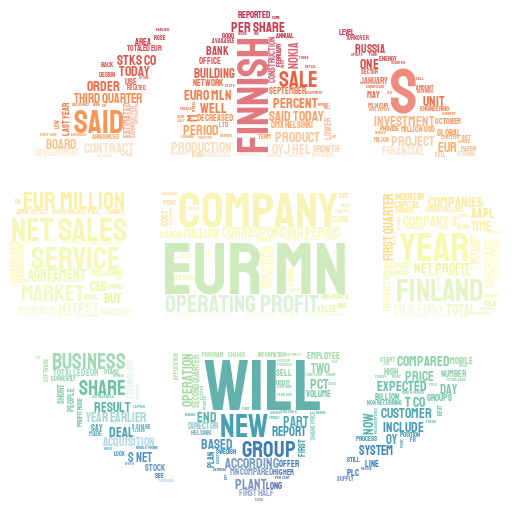

In [10]:
sentences = df['Sentence'].tolist()
corpus = " ".join(sentences)
stylecloud.gen_stylecloud(corpus,
                          icon_name = 'fas fa-globe',
                          palette='colorbrewer.diverging.Spectral_11',
                          background_color='white',gradient='vertical',stopwords=True
                          )


Image(filename='stylecloud.png')

# Predictive Modelling 

For modelling, let's go with the SGDClassifier as they are regarded as one of the best statistical methods for text classification.

In [11]:
X_train,X_test,y_train,y_test = train_test_split(df['Sentence'], df['Sentiment'])
SD_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1,2))),('clf',  SGDClassifier(class_weight = 'balanced',max_iter=10000,n_iter_no_change=10))])

SD_clf.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=10000,
                               n_iter_no_change=10))])

In [12]:
SD_clf.score(X_test, y_test)

0.6639288158795346

That's a pretty poor score, imbalance is probably the reason. Inspecting classification-metrics can help clarify

In [13]:
y_pred = SD_clf.predict(X_test)
pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).T

,precision,recall,f1-score,support
negative,0.253521,0.275510,0.264059,196.000000
neutral,0.734615,0.715356,0.724858,801.000000
positive,0.732906,0.739224,0.736052,464.000000
accuracy,0.663929,0.663929,0.663929,0.663929
macro avg,0.573681,0.576697,0.574989,1461.000000
weighted avg,0.669531,0.663929,0.666594,1461.000000


The extremely poor precision and recall scores for the 'negative' class confirms that class-imabalance is indeed the issue

Oversampling the negative and positive classes could help.

In [15]:
df_neutral = df[(df['Sentiment']=='neutral')] 
df_negative = df[(df['Sentiment']=='negative')]
df_positive = df[(df['Sentiment']=='positive')]


# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  

df_positive_upsampled = resample(df_positive, 
                                 replace=True,    
                                 n_samples= 2000, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
df_upsampled = pd.concat([df_negative_upsampled,df_neutral,df_positive_upsampled])

Fitting the model again where the negative and positive class is oversampled by 2000 samples each

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df_upsampled['Sentence'], df_upsampled['Sentiment'])
SD_clf_upsampled = Pipeline([('cv', CountVectorizer(ngram_range=(1,2))),('clf',  SGDClassifier(class_weight = 'balanced',max_iter=20000,n_iter_no_change=10))])

SD_clf_upsampled.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=20000,
                               n_iter_no_change=10))])

In [18]:
SD_clf_upsampled.score(X_test, y_test)

0.8109927089175547

81% now!, that's a pretty impressive step-up from the model trained with the unsampled dataset.

In [19]:
y_pred = SD_clf_upsampled.predict(X_test)
pd.DataFrame(classification_report(y_pred,y_test,output_dict=True)).T

,precision,recall,f1-score,support
negative,0.880478,0.736667,0.802178,600.000000
neutral,0.780362,0.820652,0.800000,736.000000
positive,0.788955,0.894855,0.838574,447.000000
accuracy,0.810993,0.810993,0.810993,0.810993
macro avg,0.816598,0.817391,0.813584,1783.000000
weighted avg,0.816206,0.810993,0.810404,1783.000000


Precision, Recall and F1 have increased for all the classes

Finally, Eli5 can assist with interpreting the model

In [20]:
eli5.explain_weights(SD_clf_upsampled)

Explanation(estimator="Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),\n                ('clf',\n                 SGDClassifier(class_weight='balanced', max_iter=20000,\n                               n_iter_no_change=10))])", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='negative', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='down', weight=1.528834098473848, std=None, value=None), FeatureWeight(feature='decreased', weight=1.1732550748973638, std=None, value=None), FeatureWeight(feature='lower', weight=1.1109327414562613, std=None, value=None), FeatureWeight(feature='recall', weight=1.0406792912917358, std=None, value=None), FeatureWeight(feature='short', weight=0.9757107570372888, std=None, value=None), FeatureWeight(feature='decreased to', weight=0.9145936239666141, std=None, value=None), FeatureWeight(feature='tsla recall', weight=0.9005878482332351, std=None, value=None), FeatureWeight(feature='spy', weight=0.8811960994158385, std=None, value=None), FeatureWeight(feature='fall', weight=0.8326175416275902, std=None, value=None), FeatureWeight(feature='tsla', weight=0.809393105917903, std=None, value=None), FeatureWeight(feature='declined', weight=0.7936618725113225, std=None, value=None), FeatureWeight(feature='dropped', weight=0.758093490150452, std=None, value=None), FeatureWeight(feature='fell', weight=0.7481225156572, std=None, value=None), FeatureWeight(feature='to eur', weight=0.732657025189446, std=None, value=None), FeatureWeight(feature='jobs', weight=0.7289104240378869, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.7594886007030122, std=None, value=None), FeatureWeight(feature='2006 compared', weight=-1.1728433604851127, std=None, value=None), FeatureWeight(feature='rose', weight=-0.8792685273948049, std=None, value=None), FeatureWeight(feature='in 2008', weight=-0.7964989590976089, std=None, value=None), FeatureWeight(feature='increased', weight=-0.725594251590054, std=None, value=None)], pos_remaining=8748, neg_remaining=19072), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='neutral', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='loan', weight=1.1772266144123598, std=None, value=None), FeatureWeight(feature='welcome', weight=0.9462965310898565, std=None, value=None), FeatureWeight(feature='income fell', weight=0.6928450707568752, std=None, value=None), FeatureWeight(feature='in 2008', weight=0.6225797699224636, std=None, value=None), FeatureWeight(feature='includes', weight=0.6223953727218864, std=None, value=None), FeatureWeight(feature='is', weight=0.6120018494301543, std=None, value=None), FeatureWeight(feature='approximately', weight=0.5747635823307358, std=None, value=None), FeatureWeight(feature='it not', weight=0.5729295777412619, std=None, value=None), FeatureWeight(feature='while sales', weight=0.5729295777412585, std=None, value=None)], neg=[FeatureWeight(feature='up from', weight=-0.7925591028935338, std=None, value=None), FeatureWeight(feature='positive', weight=-0.754448686872488, std=None, value=None), FeatureWeight(feature='increase', weight=-0.6957854585497811, std=None, value=None), FeatureWeight(feature='negative', weight=-0.6362351301810802, std=None, value=None), FeatureWeight(feature='mn compared', weight=-0.6269056285737307, std=None, value=None), FeatureWeight(feature='mn up', weight=-0.6164348578060801, std=None, value=None), Feature

Negative classes are defined by verbs such as 'down', 'decreased', 'fall', 'lower' etc, to indicate some quantity going down.

The converse is true for positive class, verbs such as 'increased', 'up', grew', 'rise' indicate a positive sentiment.

Interestingly, Verbs not adjectives are the most important features here, usually models rely on adjectives and adverbs for sentiment classification.

The distinction between 'neutral' and 'positive' sentence is very subjective and varies across people. Any ML model is sure to have a hard time distinguishing between them.

# Closing Remarks

Finance is one of the domains where NLP techniques are being adopted at an accelerated rate, the ability to classify financial news into sentiment-defined buckets saves a lot of time & effort for workers in financial analysis based roles.

Even with a dataset of just 5.8k records, a model with decent accuracy was achieved, suggesting that more data coupled with high quality labels and the right amount of variance can make sentiment analysis the de-facto paradigm to sort financial news.